# Make a fit over an entire region of the field

This is a complete example of a fit over an entire region of interest (ROI). The different steps covered are :

1. Extraction of a deep frame and the WCS
2. Definition of the ROI with DS9
3. Fit of a single spectrum in order to get an initial guess on the velocity of the gas
4. Fit of the entire ROI
5. Visualization of the resulting maps

In [1]:
%matplotlib inline
from orcs.process import SpectralCube
import pylab as pl
import orb.utils.io
import numpy as np

In [2]:
cube = SpectralCube('/home/thomas/M57_SN3.merged.cm1.1.0.hdf5', debug=False)

INFO| Data shape : (2048, 2064, 593)
INFO| Cube is in WAVENUMBER (cm-1)
INFO| Cube is CALIBRATED in wavenumber


## Export the deep frame with its WCS to define the ROI

INFO| Data written as deep_frame.fits in 0.24 s 


'deep_frame.fits'

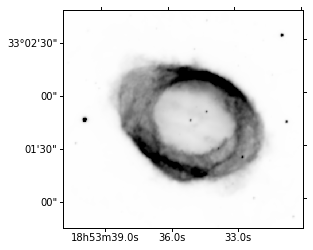

In [3]:
deep_frame = cube.get_deep_frame()
fig = pl.figure()
ax = fig.add_subplot(111, projection=cube.get_wcs())
ax.coords[0].set_major_formatter('hh:mm:ss.s')
ax.coords[1].set_major_formatter('dd:mm:ss')
pl.imshow(deep_frame.T, origin='bottom-left', 
          vmin=np.nanpercentile(deep_frame, 0.1),
          vmax=np.nanpercentile(deep_frame, 99.9),
          cmap='gray_r')
pl.xlim((550,970))
pl.ylim((650,1030))
orb.utils.io.write_fits('deep_frame.fits', deep_frame, fits_header=cube.get_wcs_header(), overwrite=True)

## Use ds9 to define the ROI

from here you can use ds9 to define the region of interest on the deep frame. You can export the region in celestial or image coordinates. Note that the region can also be passed as a collection of pixel position as it is returned by a function such as numpy.nonzero(). the content of the generated ds9 region file is:

It can be plotted (for checking purpose) with pyregion (http://pyregion.readthedocs.io/en/latest/index.html) like this

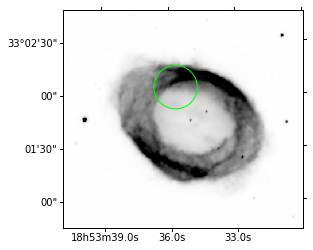

In [4]:
import pyregion

# draw the background image
fig = pl.figure()
ax = fig.add_subplot(111, projection=cube.get_wcs())
ax.coords[0].set_major_formatter('hh:mm:ss.s')
ax.coords[1].set_major_formatter('dd:mm:ss')

pl.imshow(deep_frame.T, origin='bottom-left', 
          vmin=np.nanpercentile(deep_frame, 0.1),
          vmax=np.nanpercentile(deep_frame, 99.9),
          cmap='gray_r')
pl.xlim((550,970))
pl.ylim((650,1030))

# load region file and draw the regions
reg = pyregion.open('region.reg').as_imagecoord(cube.get_wcs_header())

patch_list, artist_list = reg.get_mpl_patches_texts()
for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)
    

## Extract a spectrum of the region to define the fit parameters

INFO| Number of integrated pixels: 29


 [==========] [100%] [completed in 0.013 s]                                   

INFO| Init of the parallel processing server with 4 threads



 [==========] [100%] [completed in 0.460 s]                                   


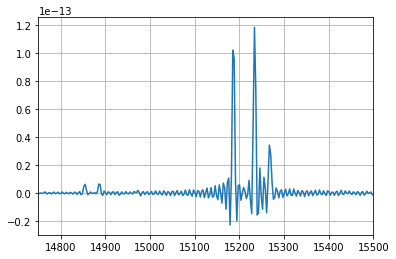

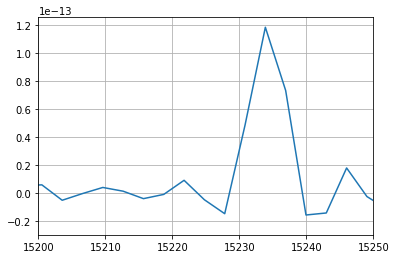

In [5]:
axis, spectrum = cube.extract_spectrum(749, 898, 3)

# all the spectrum
pl.figure()
pl.plot(axis, spectrum)
pl.xlim((14750,15500))
pl.grid()

# zoom over Halpha
pl.figure()
pl.plot(axis, spectrum)
pl.xlim((15200,15250))
pl.grid()


In [6]:
# Halpha wavenumber is roughly 15235 cm-1 which gives a velocity :

import orb.utils.spectrum
from orb.core import Lines
vel = orb.utils.spectrum.compute_radial_velocity(15235, Lines().get_line_cm1('Halpha'), wavenumber=True)
print 'velocity: {} km/s'.format(vel)

velocity: 47.1970433253 km/s


INFO| Number of integrated pixels: 29


 [==========] [100%] [completed in 0.011 s]                                   

INFO| Init of the parallel processing server with 4 threads



 [==========] [100%] [completed in 0.468 s]                                   

WARNING| /home/thomas/Astro/Python/ORB/Orcs/orcs/core.py:1673: RuntimeWarning: invalid value encountered in sqrt
  noise_counts = np.sqrt(total_counts)



WARNING| /home/thomas/Astro/Python/ORB/Orb/orb/fit.py:2074: UserWarning: please set a guess, or a covarying value of sigma > 0 or use a  sinc model or you might end up with nans
  warnings.warn('please set a guess, or a covarying value of sigma > 0 or use a  sinc model or you might end up with nans')



Velocity (km/s):  [77.74(32) 68.20(13) 77.74(32) 77.74(32) 77.74(32)]
Broadening (km/s) [21.43(88) 20.13(36) 21.43(88) 21.43(88) 21.43(88)]


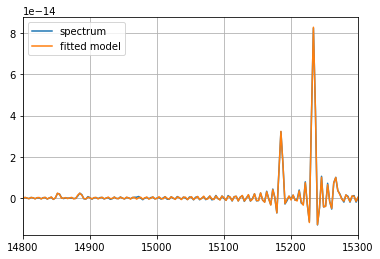

In [7]:
# set up the fit to check if before running the long extraction process over the whole ROI

axis, spectrum, fit = cube.fit_lines_in_spectrum(733, 886, 3, 
                                                 ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                                                 fmodel='sincgauss', 
                                                 pos_def=['1','2','1','1','1'], 
                                                 pos_cov=[vel, vel],
                                                 sigma_def=['1','2','1','1','1'],
                                                 sigma_cov=[20, 20],
                                                 snr_guess=None,
                                                 nofilter=True)

print 'Velocity (km/s): ', fit['velocity_gvar']
print 'Broadening (km/s)', fit['broadening_gvar']
new_vel = fit['velocity'][0], fit['velocity'][1]
                                                 
pl.figure()
pl.plot(axis, spectrum, label='spectrum')
pl.plot(axis, fit['fitted_vector'], label='fitted model')
pl.xlim((14800,15300))
pl.legend()
pl.grid()

## Fit the ROI

We are ready to fit all the spectra in the defined ROI.

- On very high SNR data it's better to set snr_guess='auto' and use the bayesian fit mode even if it's longer since there are some instabilities on the classic fit due to the numerical computation of the jacobian. Note that a classical fit (snr_guess=None) will still give mostly relieable results although some pixels in the maps can be slightly biased with respect to their neighbourhood but the uncertainty will be a NaN so that they can be filtered.

- The guess on sigma must be small -- as small as the smaller sigma you expect -- but not too small (< 0.1 km/s). 1 km/s is a good guess. In theory we can expect a sigma of 0 km/s for unbroadened lines but the loss of modulation efficiency can broaden the line by a few km/s (see Baril et al. 2016 http://proceedings.spiedigitallibrary.org/proceeding.aspx?doi=10.1117/12.2232075 and Martin et al. 2016 http://cdsads.u-strasbg.fr/abs/2016MNRAS.463.4223M)

- Don't hesitate to fit binned data first, you will gain time and SNR which is a good way to check fitting errors.

- warning: for unknown reasons you can have an error if the fit below is done more than one time. Just restart the kernel as a workaround.

### 3x3 binning

In [11]:
orb.core.Logger(debug=True)
cube.fit_lines_in_region('region.reg', 
                         ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                         fmodel='sinc', 
                         pos_def=['1','2','1','1','1'], 
                         pos_cov=new_vel,
                         #sigma_def=['1','2','1','1','1'], 
                         #sigma_cov=[10, 10],
                         binning=3, snr_guess='auto',
                         nofilter=True)

WARNING| /home/thomas/Astro/Python/ORB/Orb/orb/core.py:242: UserWarning: Exception occured during logging server init (maybe it is already initialized): [Errno 98] Address already in use
  warnings.warn('Exception occured during logging server init (maybe it is already initialized): {}'.format(e))



 loading region: Shape : circle ( HMS(18:53:35.739),DMS(+33:02:03.821),Ang(12.264") )



INFO| Number of spectra to fit: 501
INFO| Init of the parallel processing server with 4 threads
INFO| passed mapped kwargs : []
INFO| 26 rows to fit


 [==========] [100%] [completed in 4m11s]                                     

INFO| Writing height maps
WARNING| param height is the same for all lines


INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.all.3x3.height.fits in 0.03 s 
INFO| Writing height-err maps
WARNING| param height-err is the same for all lines
INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.all.3x3.height-err.fits in 0.01 s 
INFO| Writing amplitude maps
INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6548.3x3.amplitude.fits in 0.01 s 
INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6563.3x3.amplitude.fits in 0.01 s 
INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.3x3.amplitude.fits in 0.01 s 
INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6716.3x3.amplitude.fits in 0.01 s 
INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6731.3x3.amplitude.fits in 0.01 s 
INFO| Writing amplitude-err maps
INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6548.3x3.amplitude-err.fits in 0.01 s 
INFO| Data written as M5

###  Check the results


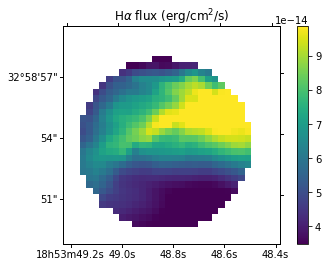

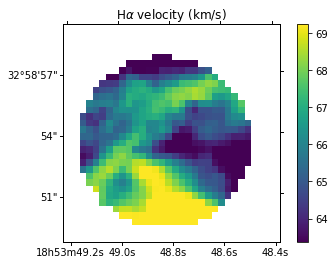

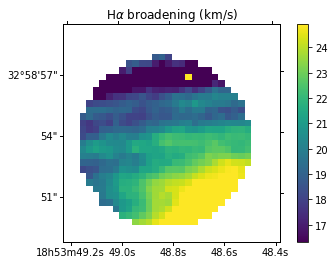

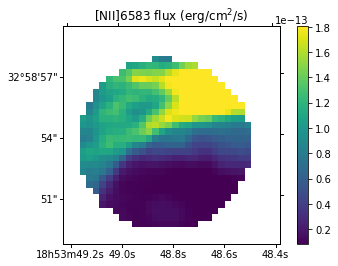

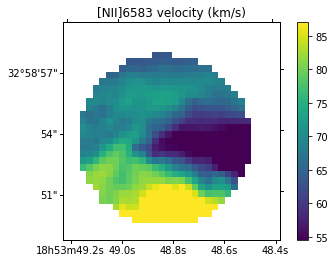

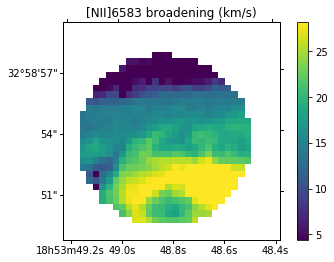

In [12]:
def show_map(path, title):
    fig = pl.figure()
    ax = fig.add_subplot(111, projection=cube.get_wcs())
    ax.coords[0].set_major_formatter('hh:mm:ss.s')
    ax.coords[1].set_major_formatter('dd:mm:ss')
    _map = orb.utils.io.read_fits(path)
    pl.imshow(_map.T, origin='bottom-left', 
              vmin=np.nanpercentile(_map, 10),
              vmax=np.nanpercentile(_map, 90))
    pl.xlim((700/3,800/3))
    pl.ylim((850/3,950/3))
    pl.colorbar()
    pl.title(title)
    
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6563.3x3.flux.fits', r'H$\alpha$ flux (erg/cm$^2$/s)')
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6563.3x3.velocity.fits', r'H$\alpha$ velocity (km/s)')
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6563.3x3.sigma.fits', r'H$\alpha$ broadening (km/s)')

show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.3x3.flux.fits', r'[NII]6583 flux (erg/cm$^2$/s)')
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.3x3.velocity.fits', r'[NII]6583 velocity (km/s)')
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.3x3.sigma.fits', r'[NII]6583 broadening (km/s)')


### 1x1 binning

In [9]:
cube.fit_lines_in_region('region.reg', 
                         ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                         fmodel='sincgauss', 
                         pos_def=['1','2','1','1','1'], 
                         pos_cov=new_vel,
                         sigma_def=['1','2','1','1','1'], 
                         sigma_cov=1,
                         binning=1, snr_guess='auto',
                         no_filter=True)

 loading region: Shape : circle ( HMS(18:53:35.739),DMS(+33:02:03.821),Ang(12.264") )



WARNING| /home/thomas/Astro/Python/ORB/Orcs/orcs/core.py:654: RuntimeWarning: invalid value encountered in greater
  np.nonzero(np.abs(init_velocity_map_err) > max_vel_err)] = np.nan

WARNING| /home/thomas/Astro/Python/ORB/Orcs/orcs/core.py:658: RuntimeWarning: invalid value encountered in divide
  init_velocity_map /= np.nansum(vel_map_w, axis=2)

WARNING| /home/thomas/Astro/Python/ORB/Orcs/orcs/core.py:663: RuntimeWarning: invalid value encountered in greater
  np.nonzero(np.abs(init_sigma_map_err) > max_sig_err)] = np.nan

WARNING| /home/thomas/Astro/Python/ORB/Orcs/orcs/core.py:667: RuntimeWarning: invalid value encountered in divide
  init_sigma_map /= np.nansum(sig_map_w, axis=2)

INFO| Number of spectra to fit: 4509
WARNING| /home/thomas/Astro/Python/ORB/Orb/orb/utils/image.py:938: RuntimeWarning: Mean of empty slice
  return np.squeeze(np.nanmean(np.nanmean(im_view, axis=3), axis=1))

INFO| Init of the parallel processing server with 16 threads
INFO| 76 lines to fit


 [==========] [100%] [completed in 15m47s]                                    


INFO| Writing height maps
WARNING| param height is the same for all lines
WARNING| /usr/local/lib/python2.7/dist-packages/astropy/wcs/wcs.py:2561: AstropyWarning: Some non-standard WCS keywords were excluded: BP_0_0, BP_0_1, BP_0_2, A_3_0, B_3_0, BP_3_0, B_1_2, B_1_0, B_1_1, B_2_1, B_2_0, A_ORDER, B_0_3, B_0_2, B_0_1, B_0_0, BP_0_3, B_ORDER, BP_ORDER, BP_1_2, AP_ORDER, AP_3_0, A_1_1, A_1_0, BP_2_0, A_1_2, AP_2_1, AP_2_0, A_0_0, A_0_1, A_0_2, A_0_3, BP_1_1, BP_1_0, A_2_0, A_2_1, AP_1_0, AP_1_1, AP_1_2, BP_2_1, AP_0_1, AP_0_0, AP_0_3, AP_0_2 Use the ``relax`` kwarg to control this.
  AstropyWarning)

INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.all.1x1.height.fits in 0.03 s 
INFO| Writing height-err maps
WARNING| param height-err is the same for all lines
INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.all.1x1.height-err.fits in 0.03 s 
INFO| Writing amplitude maps
INFO| Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6548.1x1.a

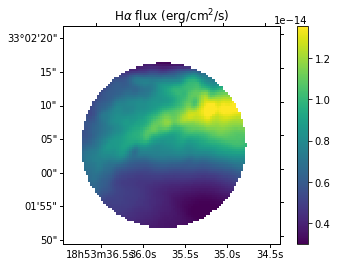

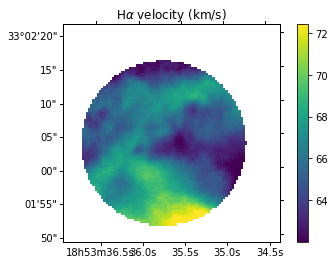

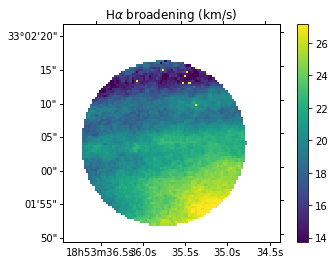

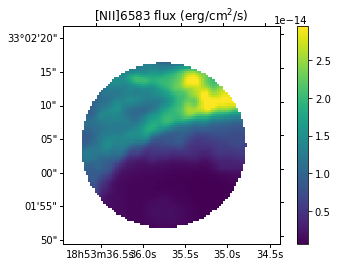

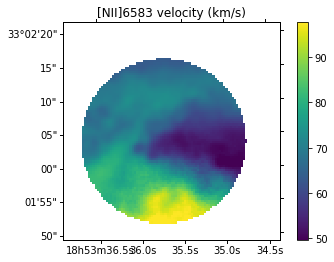

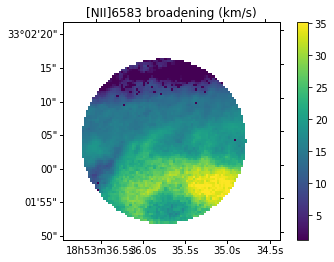

In [10]:
def show_map(path, title):
    fig = pl.figure()
    ax = fig.add_subplot(111, projection=cube.get_wcs())
    ax.coords[0].set_major_formatter('hh:mm:ss.s')
    ax.coords[1].set_major_formatter('dd:mm:ss')
    _map = orb.utils.io.read_fits(path)
    pl.imshow(_map.T, origin='bottom-left', 
              vmin=np.nanpercentile(_map, 1),
              vmax=np.nanpercentile(_map, 99))
    pl.xlim((700,800))
    pl.ylim((850,950))
    pl.colorbar()
    pl.title(title)
    
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6563.1x1.flux.fits', r'H$\alpha$ flux (erg/cm$^2$/s)')
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6563.1x1.velocity.fits', r'H$\alpha$ velocity (km/s)')
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6563.1x1.sigma.fits', r'H$\alpha$ broadening (km/s)')

show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.1x1.flux.fits', r'[NII]6583 flux (erg/cm$^2$/s)')
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.1x1.velocity.fits', r'[NII]6583 velocity (km/s)')
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.1x1.sigma.fits', r'[NII]6583 broadening (km/s)')
